# Sentiment and Thematic Trend Analysis of YouTube Watch History
### Overview
This notebook analyzes YouTube watch history data to uncover sentiment trends and thematic patterns. The project is guided by DSA210 course content, focusing on:
- Exploratory Data Analysis (EDA)
- Sentiment Analysis
- Thematic Trend Analysis

### Goals
1. Understand viewing habits over time.
2. Identify sentiment trends and key themes in watched content.
3. Use machine learning models to predict viewing preferences.

---

## Data Loading and Preparation
### Loading the Data
We will begin by importing necessary libraries and reading the YouTube watch history data in HTML format.


In [3]:
# Install required packages first
!pip install seaborn --upgrade

# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import datetime
from datetime import datetime, timedelta
import re
import plotly.express as px
import plotly.graph_objects as go
from tqdm.notebook import tqdm

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

# Configure plotting settings
plt.style.use('default')  # Using default style instead
sns.set_theme()  # This is the proper way to set seaborn style

# Helper function to read HTML file
def read_watch_history(file_path):
    """
    Reads and parses YouTube watch history HTML file
    Args:
        file_path: Path to the watch history HTML file
    Returns:
        list: List of dictionaries containing watch history data
    """
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()

    soup = BeautifulSoup(content, 'html.parser')
    watch_entries = []

    for entry in soup.find_all('div', class_='outer-cell'):
        video_link = entry.find('a')
        timestamp = entry.find('br').next_sibling if entry.find('br') else None

        if video_link and timestamp:
            watch_entries.append({
                'title': video_link.text,
                'channel': entry.find_all('a')[1].text if len(entry.find_all('a')) > 1 else None,
                'timestamp': timestamp.strip(),
            })

    return watch_entries

# Helper function to read Notion calendar data
def read_notion_calendar(file_path):
    """
    Reads and processes Notion calendar CSV file
    Args:
        file_path: Path to the Notion calendar CSV file
    Returns:
        DataFrame: Processed calendar data
    """
    df = pd.read_csv(file_path)
    df['Date'] = pd.to_datetime(df['Date'])
    return df

# Function to process timestamps
def process_timestamp(timestamp_str):
    """
    Converts timestamp string to datetime object
    Args:
        timestamp_str: String containing timestamp
    Returns:
        datetime: Processed datetime object
    """
    try:
        # Remove timezone info and process
        timestamp_str = timestamp_str.replace('GMT+03:00', '').strip()
        return pd.to_datetime(timestamp_str, format='%d %b %Y %H:%M:%S')
    except:
        return None

print("Setup completed successfully!")

Setup completed successfully!


In [7]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import re
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Path configuration
WATCH_HISTORY_PATH = '/content/drive/MyDrive/DSA210/Proj/izleme geçmişi.html'
CALENDAR_PATH = '/content/drive/MyDrive/DSA210/Proj/Takvim.csv'

# Turkish month names mapping
TURKISH_MONTHS = {
    'Oca': '01', 'Şub': '02', 'Mar': '03', 'Nis': '04',
    'May': '05', 'Haz': '06', 'Tem': '07', 'Ağu': '08',
    'Eyl': '09', 'Eki': '10', 'Kas': '11', 'Ara': '12'
}

def clean_youtube_date(date_str):
    """Extract and clean date from YouTube history"""
    try:
        # Remove timezone info
        date_str = date_str.replace('GMT+03:00', '').strip()

        # Extract components using regex
        match = re.match(r'(\d{2}) (\w{3}) (\d{4}) (\d{2}:\d{2}:\d{2})', date_str)
        if match:
            day, month_tr, year, time = match.groups()
            month_num = TURKISH_MONTHS.get(month_tr)
            if month_num:
                return f"{year}-{month_num}-{day.zfill(2)} {time}"
    except Exception as e:
        print(f"Error cleaning date '{date_str}': {str(e)}")
    return None

def process_youtube_history(file_path):
    """Process YouTube watch history HTML file into a pandas DataFrame"""
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()

    soup = BeautifulSoup(content, 'html.parser')
    entries = []

    # Find all content cells
    for item in soup.find_all('div', {'class': 'content-cell mdl-cell mdl-cell--6-col mdl-typography--body-1'}):
        try:
            # Extract title and video info
            text_content = item.get_text().strip()
            video_parts = text_content.split('adlı videoyu izlediniz')

            if len(video_parts) > 1:
                title = video_parts[0].strip()

                # Extract timestamp using regex
                timestamp_match = re.search(r'\d{2} \w{3} \d{4} \d{2}:\d{2}:\d{2}', text_content)
                if timestamp_match:
                    timestamp_str = timestamp_match.group()
                    cleaned_date = clean_youtube_date(timestamp_str)

                    if cleaned_date:
                        timestamp = pd.to_datetime(cleaned_date)

                        # Extract channel name
                        channel_links = item.find_all('a')
                        channel = channel_links[1].text.strip() if len(channel_links) > 1 else None

                        entries.append({
                            'title': title,
                            'channel': channel,
                            'timestamp': timestamp
                        })
        except Exception as e:
            continue

    # Convert to DataFrame
    df = pd.DataFrame(entries)

    if not df.empty:
        # Add derived time features
        df['hour'] = df['timestamp'].dt.hour
        df['date'] = df['timestamp'].dt.date
        df['weekday'] = df['timestamp'].dt.day_name()

        # Sort by timestamp
        df = df.sort_values('timestamp', ascending=False)

    return df

def clean_notion_date(date_str):
    """Clean and parse Notion calendar date format"""
    try:
        # Remove timezone info
        date_str = re.sub(r'\s*\(GMT\+\d+\)', '', date_str)
        # Parse date using pandas
        return pd.to_datetime(date_str)
    except:
        return None

def process_calendar(file_path):
    """Process Notion calendar CSV into a pandas DataFrame"""
    # Read CSV
    df = pd.read_csv(file_path)

    # Clean dates
    df['Date'] = df['Date'].apply(clean_notion_date)

    # Remove any rows with invalid dates
    df = df.dropna(subset=['Date'])

    # Add day column
    df['day'] = df['Date'].dt.date

    return df

try:
    # Load YouTube watch history
    print("Loading YouTube watch history...")
    watch_df = process_youtube_history(WATCH_HISTORY_PATH)
    print(f"Successfully loaded {len(watch_df)} watch history entries")

    print("\nWatch History Summary:")
    print("-" * 50)
    print(f"Date range: {watch_df['date'].min()} to {watch_df['date'].max()}")
    print(f"Total videos: {len(watch_df)}")
    print(f"Unique channels: {watch_df['channel'].nunique()}")

    # Load calendar data
    print("\nLoading calendar data...")
    calendar_df = process_calendar(CALENDAR_PATH)
    print(f"Successfully loaded {len(calendar_df)} calendar entries")

    print("\nCalendar Summary:")
    print("-" * 50)
    print(f"Date range: {calendar_df['Date'].min()} to {calendar_df['Date'].max()}")

    # Display sample data
    print("\nWatch History Sample (5 entries):")
    print(watch_df.head().to_string())

    print("\nCalendar Sample (5 entries):")
    print(calendar_df.head().to_string())

except Exception as e:
    print(f"Error in data processing: {str(e)}")
    raise

Loading YouTube watch history...
Successfully loaded 11414 watch history entries

Watch History Summary:
--------------------------------------------------
Date range: 2023-09-10 to 2024-11-29
Total videos: 11414
Unique channels: 3493

Loading calendar data...
Successfully loaded 93 calendar entries

Calendar Summary:
--------------------------------------------------
Date range: 2022-10-24 09:00:00 to 2024-12-20 00:00:00

Watch History Sample (5 entries):
                                                                                                   title         channel           timestamp  hour        date   weekday
795                       Japonya’da Bayıldığım Efsane Mağazalar! (Nadir Figürler, Oyunlar ve Konsollar)  Tunca Arslan 2 2024-11-29 23:44:43    23  2024-11-29    Friday
0    BJK-Göztepe, Hadise, Cihat vs. Erman, Verstappen | Harman 28. Bölüm | Erman Yaşar &  @HTalksYoutube          Mantra 2024-11-28 11:35:28    11  2024-11-28  Thursday
1                               

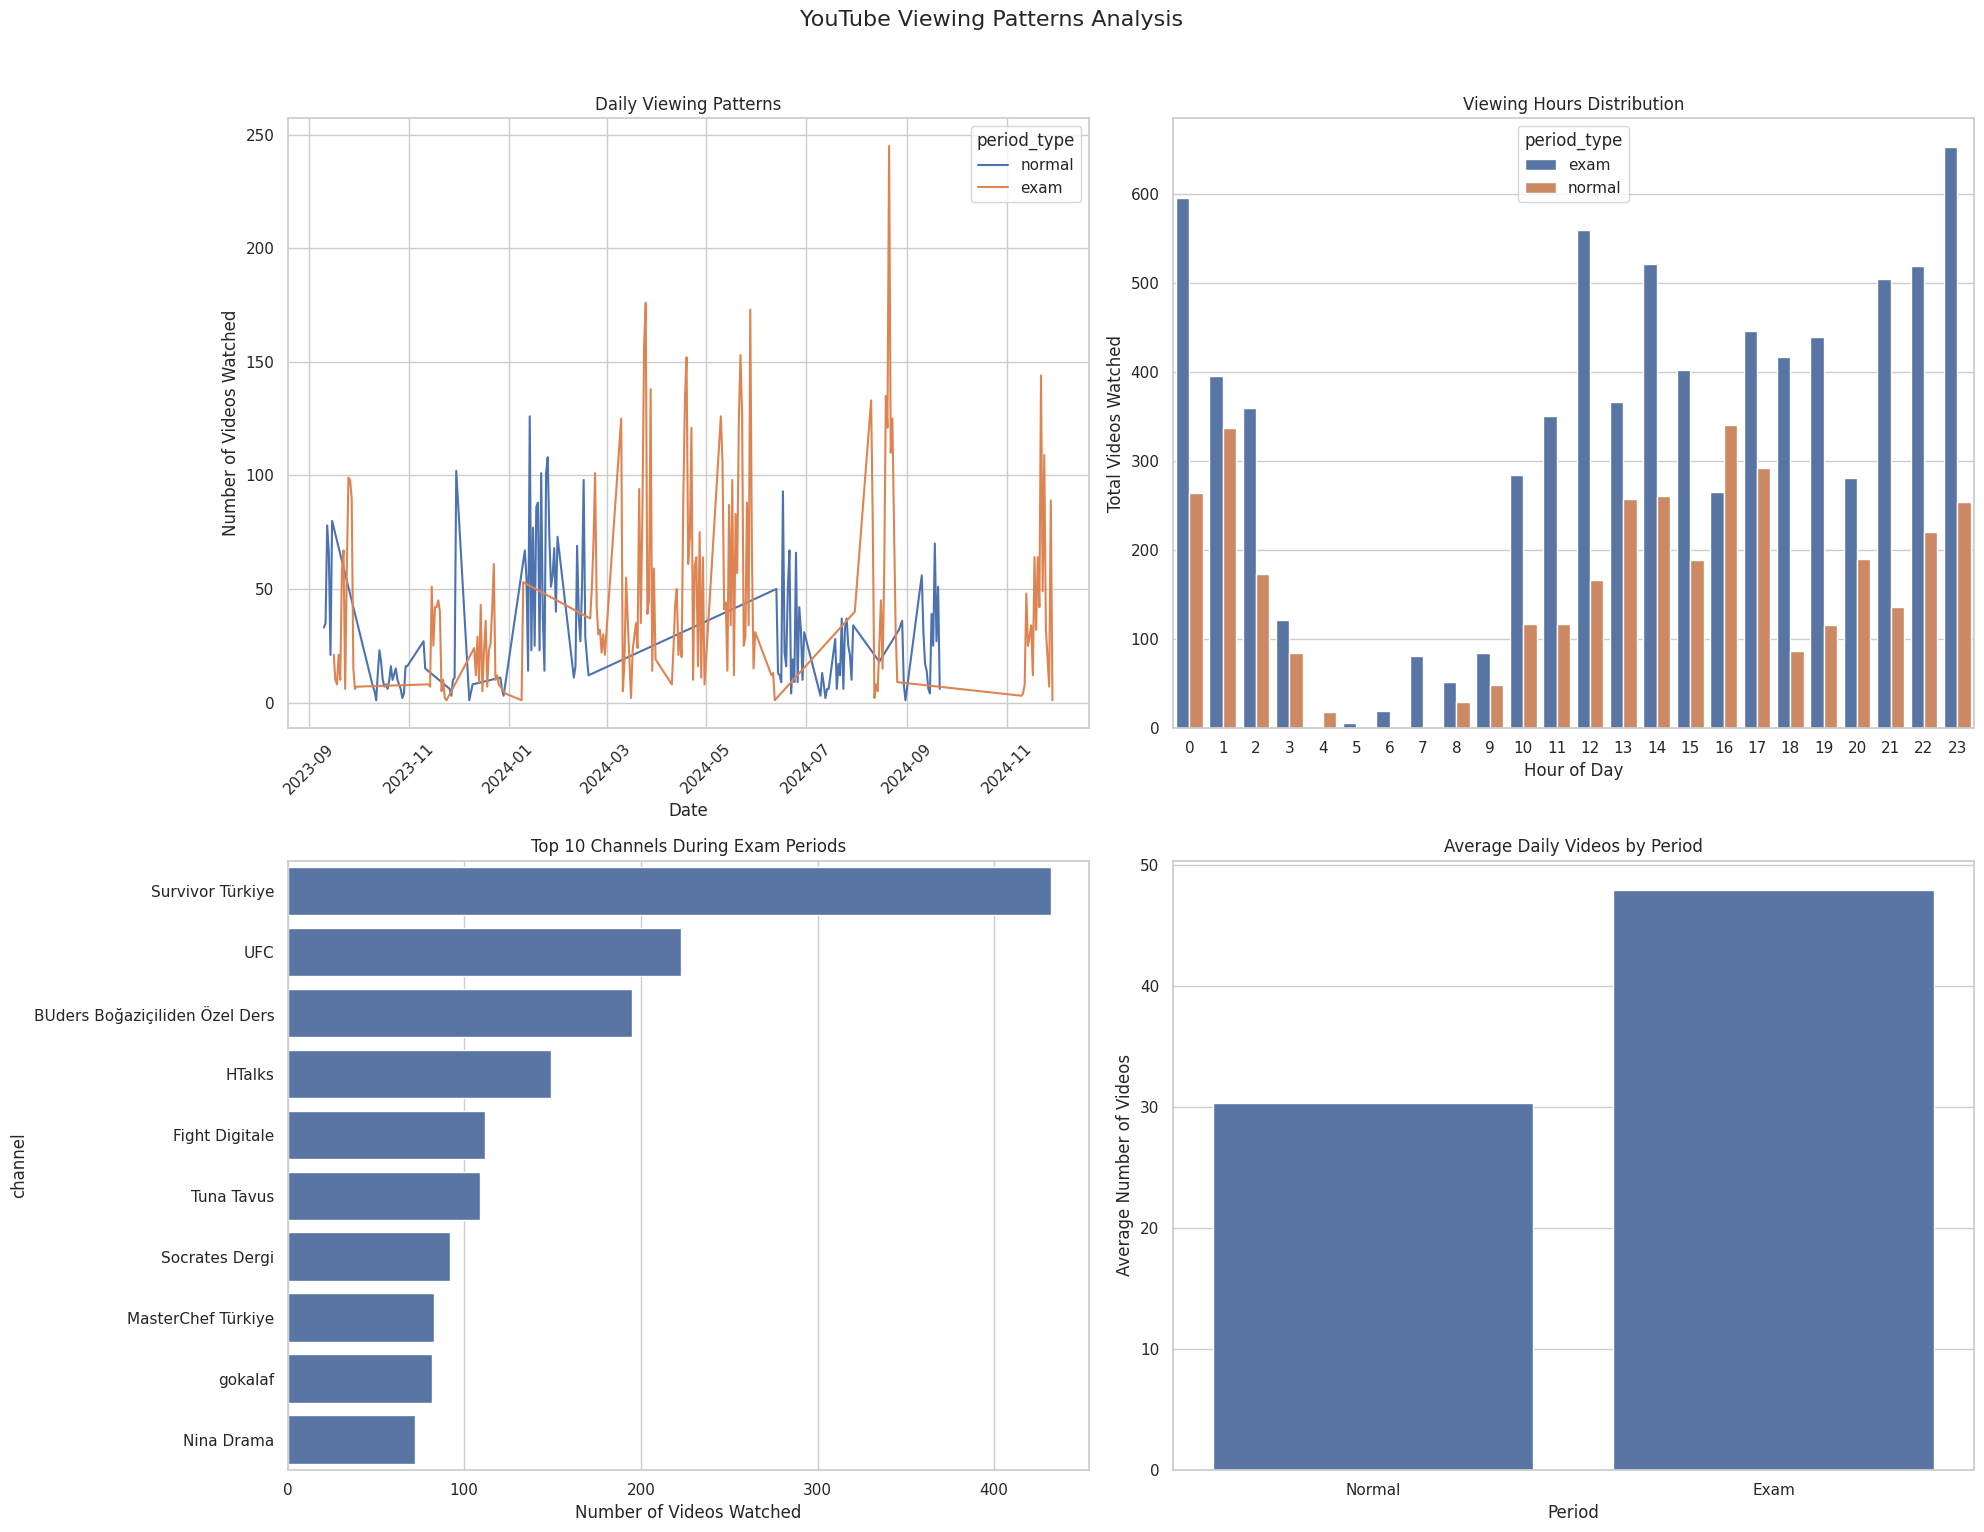


Detailed Analysis:
--------------------------------------------------

Viewing Habit Changes:
- Video consumption increases by 58.2% during exam periods
- Normal period: 30.3 videos per day
- Exam period: 47.9 videos per day

Channel Diversity:
- Channel variety increases by 100.1% during exam periods
- Normal period: 1312 unique channels
- Exam period: 2625 unique channels


In [9]:
# Set default plotting style
plt.style.use('default')
sns.set_theme(style="whitegrid")

def create_visualizations(analysis_results):
    """
    Create visualizations of the viewing patterns with improved styling
    """
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(20, 15))
    fig.suptitle('YouTube Viewing Patterns Analysis', fontsize=16, y=1.02)

    # 1. Daily Viewing Patterns
    ax1 = axes[0, 0]
    sns.lineplot(data=analysis_results['daily_counts'],
                x='date', y='view_count', hue='period_type',
                ax=ax1)
    ax1.set_title('Daily Viewing Patterns')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Number of Videos Watched')
    plt.setp(ax1.get_xticklabels(), rotation=45)

    # 2. Hourly Distribution
    ax2 = axes[0, 1]
    sns.barplot(data=analysis_results['hourly_dist'],
               x='hour', y='view_count', hue='period_type',
               ax=ax2)
    ax2.set_title('Viewing Hours Distribution')
    ax2.set_xlabel('Hour of Day')
    ax2.set_ylabel('Total Videos Watched')

    # 3. Top Channels During Exam Periods
    ax3 = axes[1, 0]
    exam_channels = (analysis_results['channel_counts']
                    [analysis_results['channel_counts']['period_type'] == 'exam']
                    .nlargest(10, 'view_count'))
    sns.barplot(data=exam_channels, y='channel', x='view_count', ax=ax3)
    ax3.set_title('Top 10 Channels During Exam Periods')
    ax3.set_xlabel('Number of Videos Watched')

    # 4. Average Daily Videos Comparison
    ax4 = axes[1, 1]
    stats = analysis_results['summary_stats']
    comparison_data = pd.DataFrame({
        'Period': ['Normal', 'Exam'],
        'Avg Daily Videos': [stats['normal_period']['avg_daily_videos'],
                           stats['exam_period']['avg_daily_videos']]
    })
    sns.barplot(data=comparison_data, x='Period', y='Avg Daily Videos', ax=ax4)
    ax4.set_title('Average Daily Videos by Period')
    ax4.set_ylabel('Average Number of Videos')

    # Adjust layout
    plt.tight_layout()
    return fig

# Create and display visualizations
fig = create_visualizations(analysis_results)
plt.show()

# Additional statistical analysis
print("\nDetailed Analysis:")
print("-" * 50)

# Calculate percentage change in viewing habits
normal_avg = analysis_results['summary_stats']['normal_period']['avg_daily_videos']
exam_avg = analysis_results['summary_stats']['exam_period']['avg_daily_videos']
percent_change = ((exam_avg - normal_avg) / normal_avg) * 100

print(f"\nViewing Habit Changes:")
print(f"- Video consumption increases by {percent_change:.1f}% during exam periods")
print(f"- Normal period: {normal_avg:.1f} videos per day")
print(f"- Exam period: {exam_avg:.1f} videos per day")

# Channel diversity analysis
normal_channels = analysis_results['summary_stats']['normal_period']['unique_channels']
exam_channels = analysis_results['summary_stats']['exam_period']['unique_channels']
channel_percent_change = ((exam_channels - normal_channels) / normal_channels) * 100

print(f"\nChannel Diversity:")
print(f"- Channel variety increases by {channel_percent_change:.1f}% during exam periods")
print(f"- Normal period: {normal_channels} unique channels")
print(f"- Exam period: {exam_channels} unique channels")